In [1]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import numpy as np
import re

import time

import sys

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.widgets import color_palette

import folium
from folium.plugins import HeatMap
from folium import branca

## 1. Data parsing

In [ ]:
# all buildings url list 

start_time = time.time()

url_list = []
prefix = 'https://dom.mingkh.ru/'

for i in range(1304):    # site pages amount
  url = f'https://dom.mingkh.ru/moskva/moskva/?page={i}'

  q = requests.get(url)
  result = q.content 

  soup = BS(result, 'lxml')
  build_list = soup.find(class_ = 'table table-condensed table-hover table-striped').find_all('a')
  
  for b in build_list:
    u = b['href']
    full_url = prefix + u
    url_list.append(full_url)

# delete same url's
url_list = list(set(url_list))

# time of url's parsing
url_parsing_time = time.time() - start_time

In [ ]:
# save url_list
f = open('data/moscow_url_list.txt', 'w')
for index in url_list:
  f.write(index + ',')
f.close()

In [ ]:
len(url_list)

32600

In [ ]:
url_parsing_time

3603.7471141815186

In [ ]:
def num_from_str(str_text):
  ''' find the int number and return the number from string

  input: text sttring with some words
  return: number like str object
  
  '''
  split_str = str_text.split(' ')
  for item in split_str:
    if item.isdigit() == True:
      num = item
  return(num)

In [ ]:
# data finding in url_list
address_list = []
year_list = []
flats_list = []
entrance_list = []
height_list = []
square_list = []
latitude_list = []
longitude_list = []
dd_list = []

start_time = time.time()

for u in url_list:
  q = requests.get(u)
  result = q.content
  soup = BS(result, 'lxml')

  # find all tr tags on page and get them text 
  page_tr_list = soup.find_all('tr')
  tr_text_list = []
  for t in page_tr_list:
    tr_text = t.text
    tr_text_list.append(tr_text)

  # check if all atributes are in tr_text_list for every building
  year_arr = []
  flats_arr = []
  entrance_arr = []
  height_arr = []
  square_arr = []
  for t in tr_text_list:
    year_arr.append(len(re.findall(r'Год ввода в эксплуатацию', t)))
    flats_arr.append(len(re.findall(r'Количество жилых помещений', t)))
    entrance_arr.append(len(re.findall(r'Количество подъездов', t)))
    height_arr.append(len(re.findall(r'Наибольшее количество этажей', t)))
    square_arr.append(len(re.findall(r'Площадь жилых помещений', t)))

  if len(set(year_arr)) > 1 and len(set(flats_arr)) > 1 and len(set(entrance_arr)) > 1 and len(set(height_arr)) > 1 and len(set(square_arr)) > 1 :

    # get values from valid tr
    for st in tr_text_list:
      if 'Год ввода в эксплуатацию' in st:
        year_list.append(int(num_from_str(st)))

      if 'Количество жилых помещений' in st:
        flats_list.append(int(num_from_str(st)))

      if 'Количество подъездов' in st:
        entrance_list.append(int(num_from_str(st)))

      if 'Наибольшее количество этажей' in st:
        height_list.append(int(num_from_str(st)))

      if 'Площадь жилых помещений' in st:
        split_str = st.split(' ')
        square_list.append(float(split_str[-2]))


    # get address from dd tag
    dd = soup.find('dd')
    dd_list.append(dd.text)

    # geo coordinates searching in got content by id, and get value

    latitude_tag = soup.find(id="mapcenterlat")
    longitude_tag = soup.find(id="mapcenterlng")
    latitude = float(latitude_tag['value'])
    longitude = float(longitude_tag['value'])
    latitude_list.append(latitude)
    longitude_list.append(longitude)  

# remove city name from address string and make address_list
for txt in dd_list:
  if 'москва' in txt.lower():
    address_str = txt.lower().rpartition(', москва, москва')
    address_list.append(address_str[0])

# time of data parsing
data_parsing_time = time.time() - start_time

In [ ]:
data_parsing_time

20729.33855843544

In [ ]:
len(address_list) == len(year_list) == len(flats_list) == len(entrance_list) == len(height_list) == len(square_list) == len(latitude_list) == len(longitude_list) 

True

In [ ]:
print(len(address_list))


31429


In [ ]:
# creating dataframe
df_base = pd.DataFrame({'Address' : address_list, 
                   'Year' : year_list, 
                   'Flats': flats_list,
                   'Entrance': entrance_list,
                   'Height' : height_list, 
                   'Square' : square_list,
                   'Latitude' : latitude_list,
                   'Longitude' : longitude_list 
                  })

# save dataframe as csv 
df_base.to_csv('data/moscow_buildings_df_base.csv')

In [6]:
df_base = pd.read_csv('data/moscow_buildings_df_base.csv').drop(columns = ['Unnamed: 0'])

In [7]:
len(df_base)

31429

In [8]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31429 entries, 0 to 31428
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Address    31429 non-null  object 
 1   Year       31429 non-null  int64  
 2   Flats      31429 non-null  int64  
 3   Entrance   31429 non-null  int64  
 4   Height     31429 non-null  int64  
 5   Square     31429 non-null  float64
 6   Latitude   31429 non-null  float64
 7   Longitude  31429 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.9+ MB


In [9]:
print(f'minimal year is {min(df_base.Year)}, maximum year is {max(df_base.Year)}')

minimal year is 169, maximum year is 2021


In [10]:
# clean base_df from unvalid data
df = df_base[(df_base['Year'] > 800) &
             (df_base['Flats'] < 10000) &
             (df_base['Entrance'] < 50) &
             (df_base['Height'] < 80) ]
df.reset_index(drop= True , inplace= True )

In [ ]:
len(df)

31423

In [ ]:
df[:5]

Address  Year  Flats  Entrance  Height  Square  \
0  малый николопесковский пер., 4  1998     29         1       7  5182.0   
1             ул. авангардная, 15  1967    111         1      14  5469.0   
2              ул. корнейчука, 36  1977     96         1      14  4089.0   
3      карамышевская, 26 корпус 1  1962     68         1       9  2471.7   
4    ул. мартеновская, 8 корпус 4  1959     60         3       5  2408.8   

    Latitude  Longitude  
0  55.750494  37.592761  
1  55.848993  37.488359  
2  55.897761  37.626367  
3  55.769595  37.477777  
4  55.757551  37.803775

## 2. Statistic analysis visualization

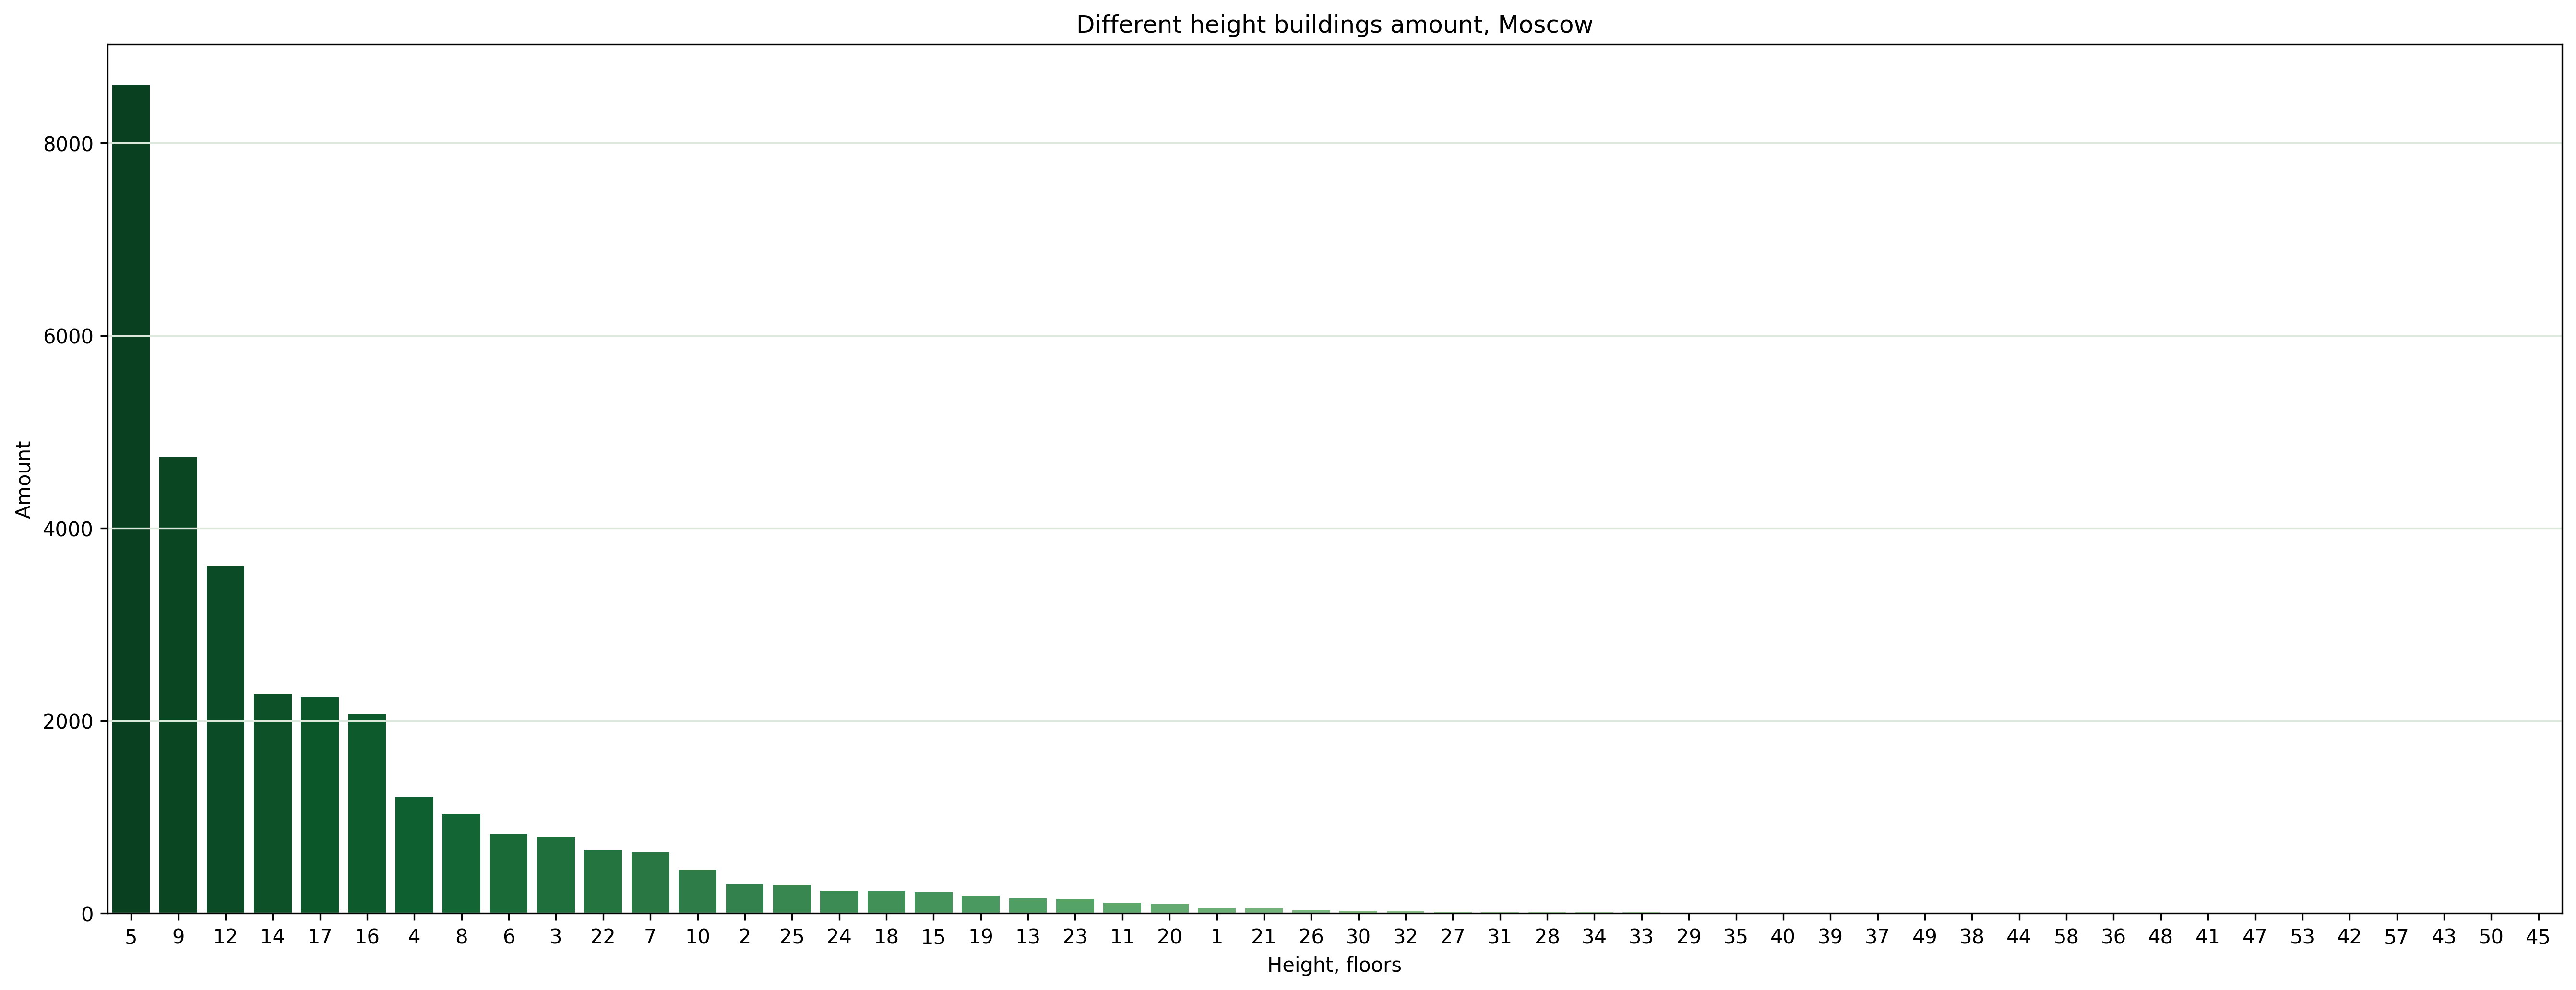

In [ ]:
# list of same height buildings amount 
height_list_a = df['Height'].value_counts()
height_list_names = list(map(str, height_list_a.index))
height_list_amount = height_list_a.values

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)

sns.barplot(x = height_list_names, y = height_list_amount,
            palette = 'Greens_r')
plt.title('Different height buildings amount, Moscow')
plt.xlabel('Height, floors')
plt.ylabel('Amount')
plt.grid(axis = 'y', color = '#dce8dc')
plt.savefig('pictures/moscow_plot_1.png')
plt.show()

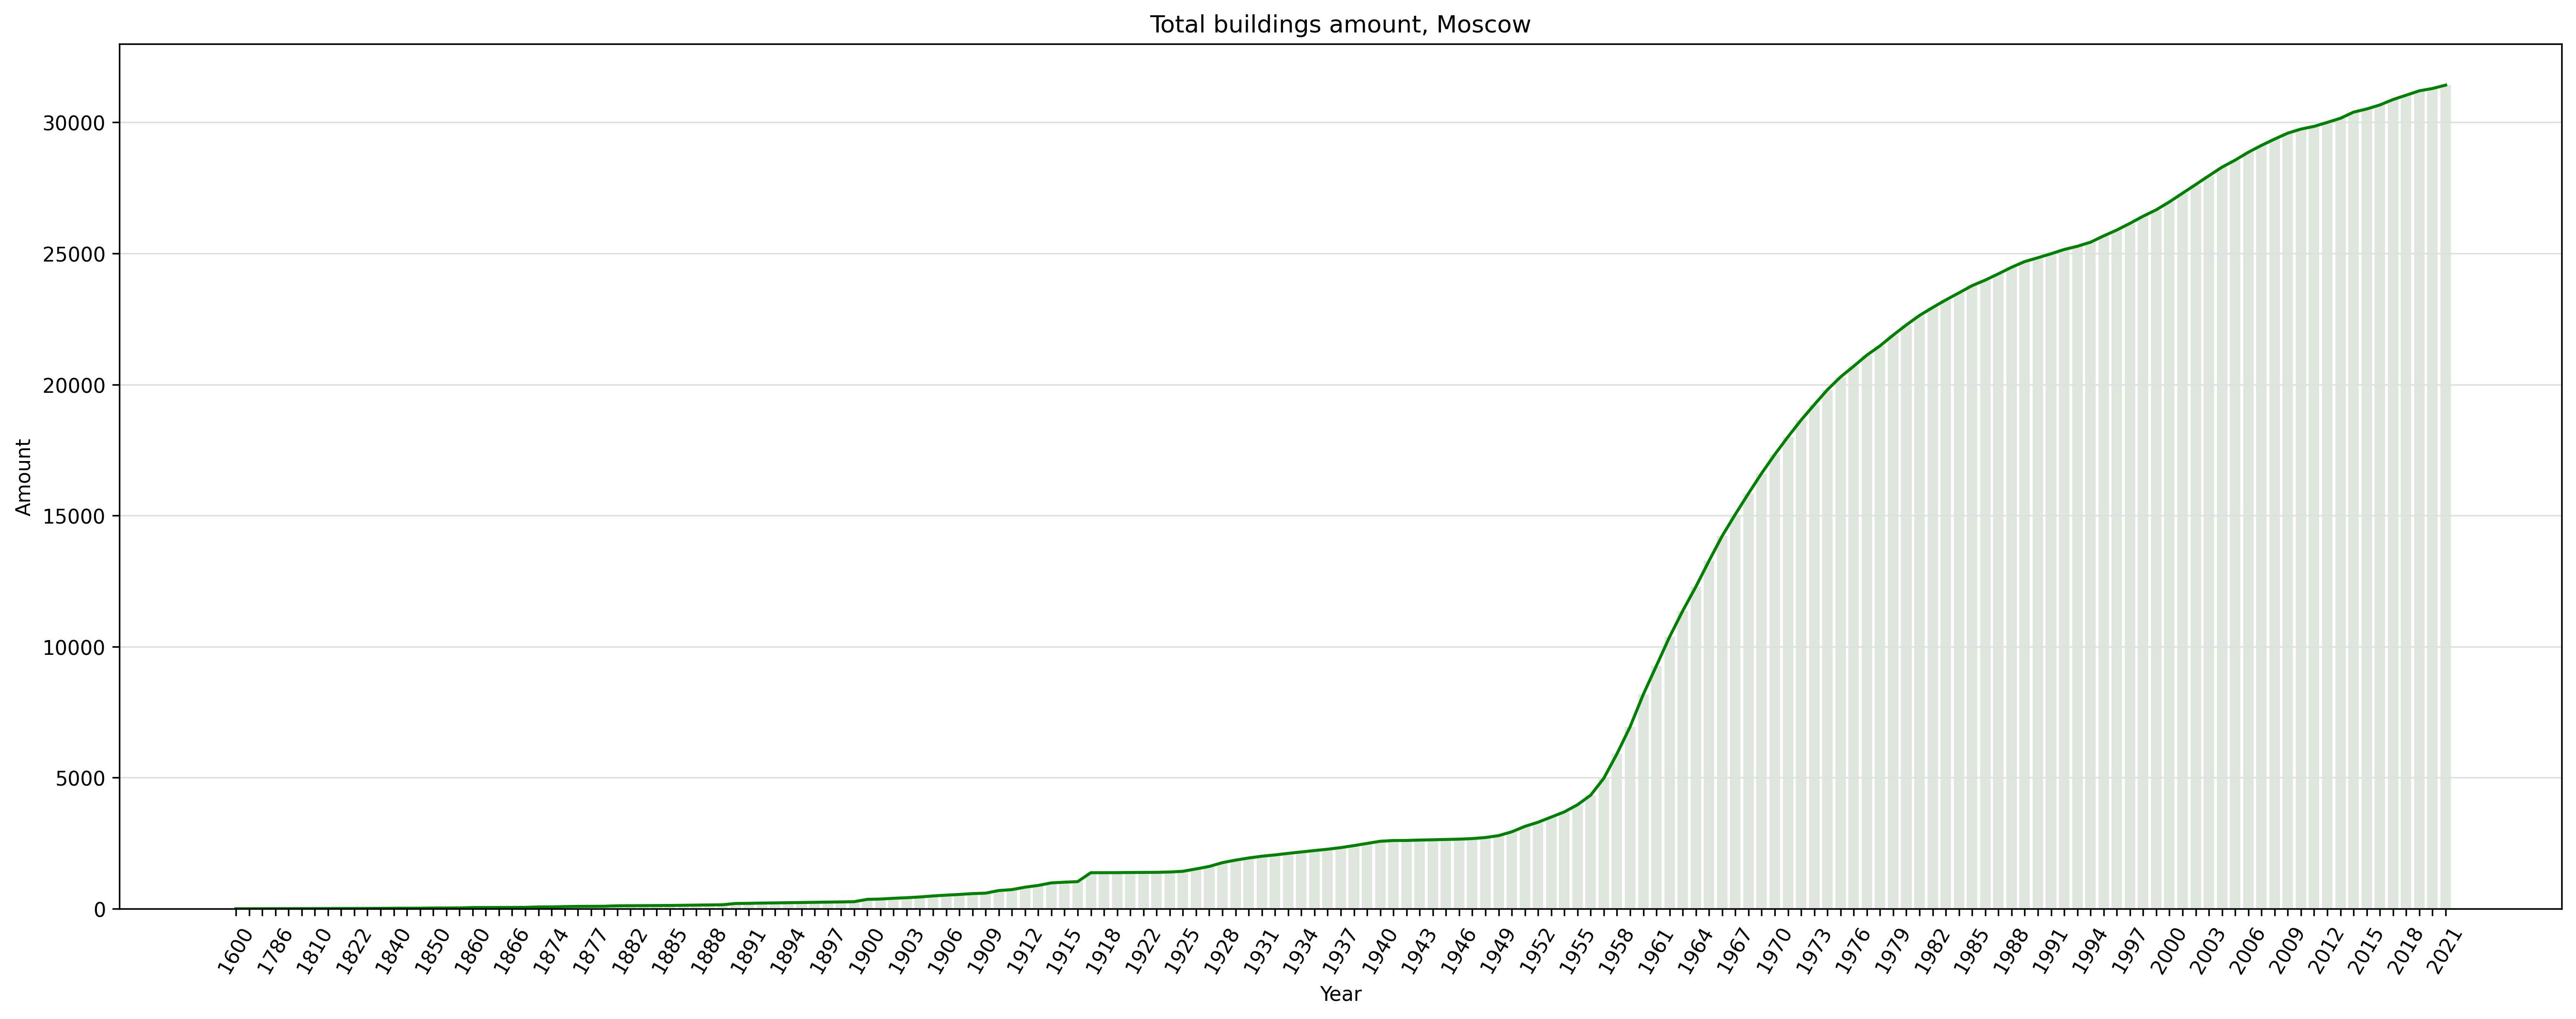

In [ ]:
# total buildings amount by years
years_list_a = df['Year'].value_counts()
years_list_sorted = years_list_a.sort_index(ascending = True)
total_years = years_list_sorted.index
total_values = []
# collect list of total buildings by every year
for i in range(len(total_years)):
  if i == 0:
    total_values.append(years_list_sorted.values[i])
  else:
    el = total_values[i-1] + years_list_sorted.values[i]
    total_values.append(el)

total_years_names = list(map(str, years_list_sorted.index))

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = total_years_names, y = total_values,
            color = '#dce8dd')
sns.lineplot(x = total_years_names, y = total_values,
            color = 'green')
plt.title('Total buildings amount, Moscow')
plt.xlabel('Year')
plt.xticks(rotation=60)
plt.ylabel('Amount')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_2.png')
plt.show()


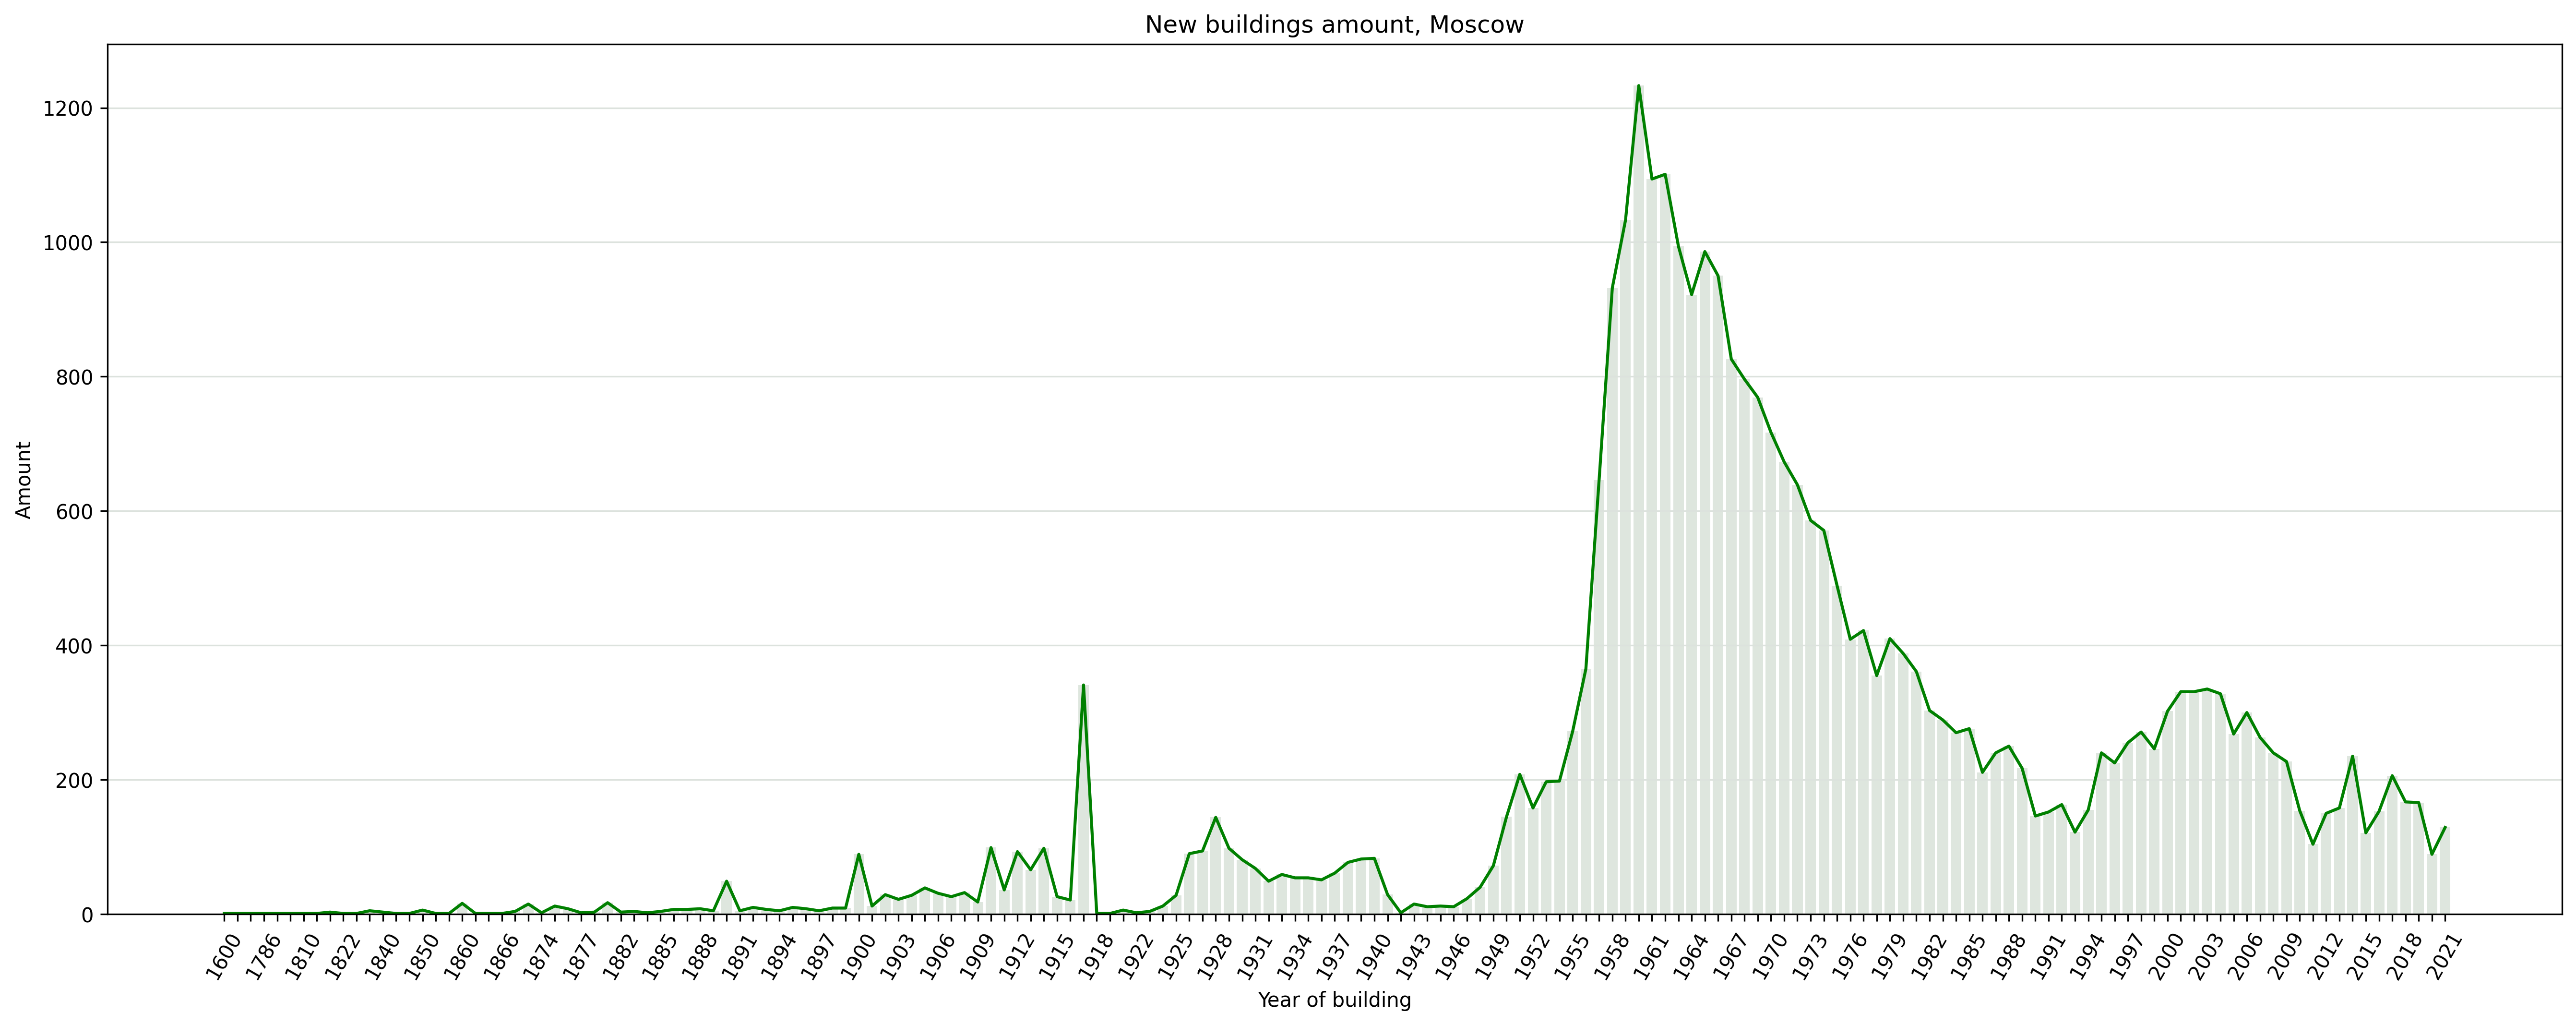

In [ ]:
# buildings by year distribution

years_list_names = list(map(str, years_list_sorted.index))
years_list_amount = years_list_sorted.values

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = years_list_amount,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = years_list_amount,
            color = 'green')
plt.title('New buildings amount, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Amount')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_3.png')
plt.show()


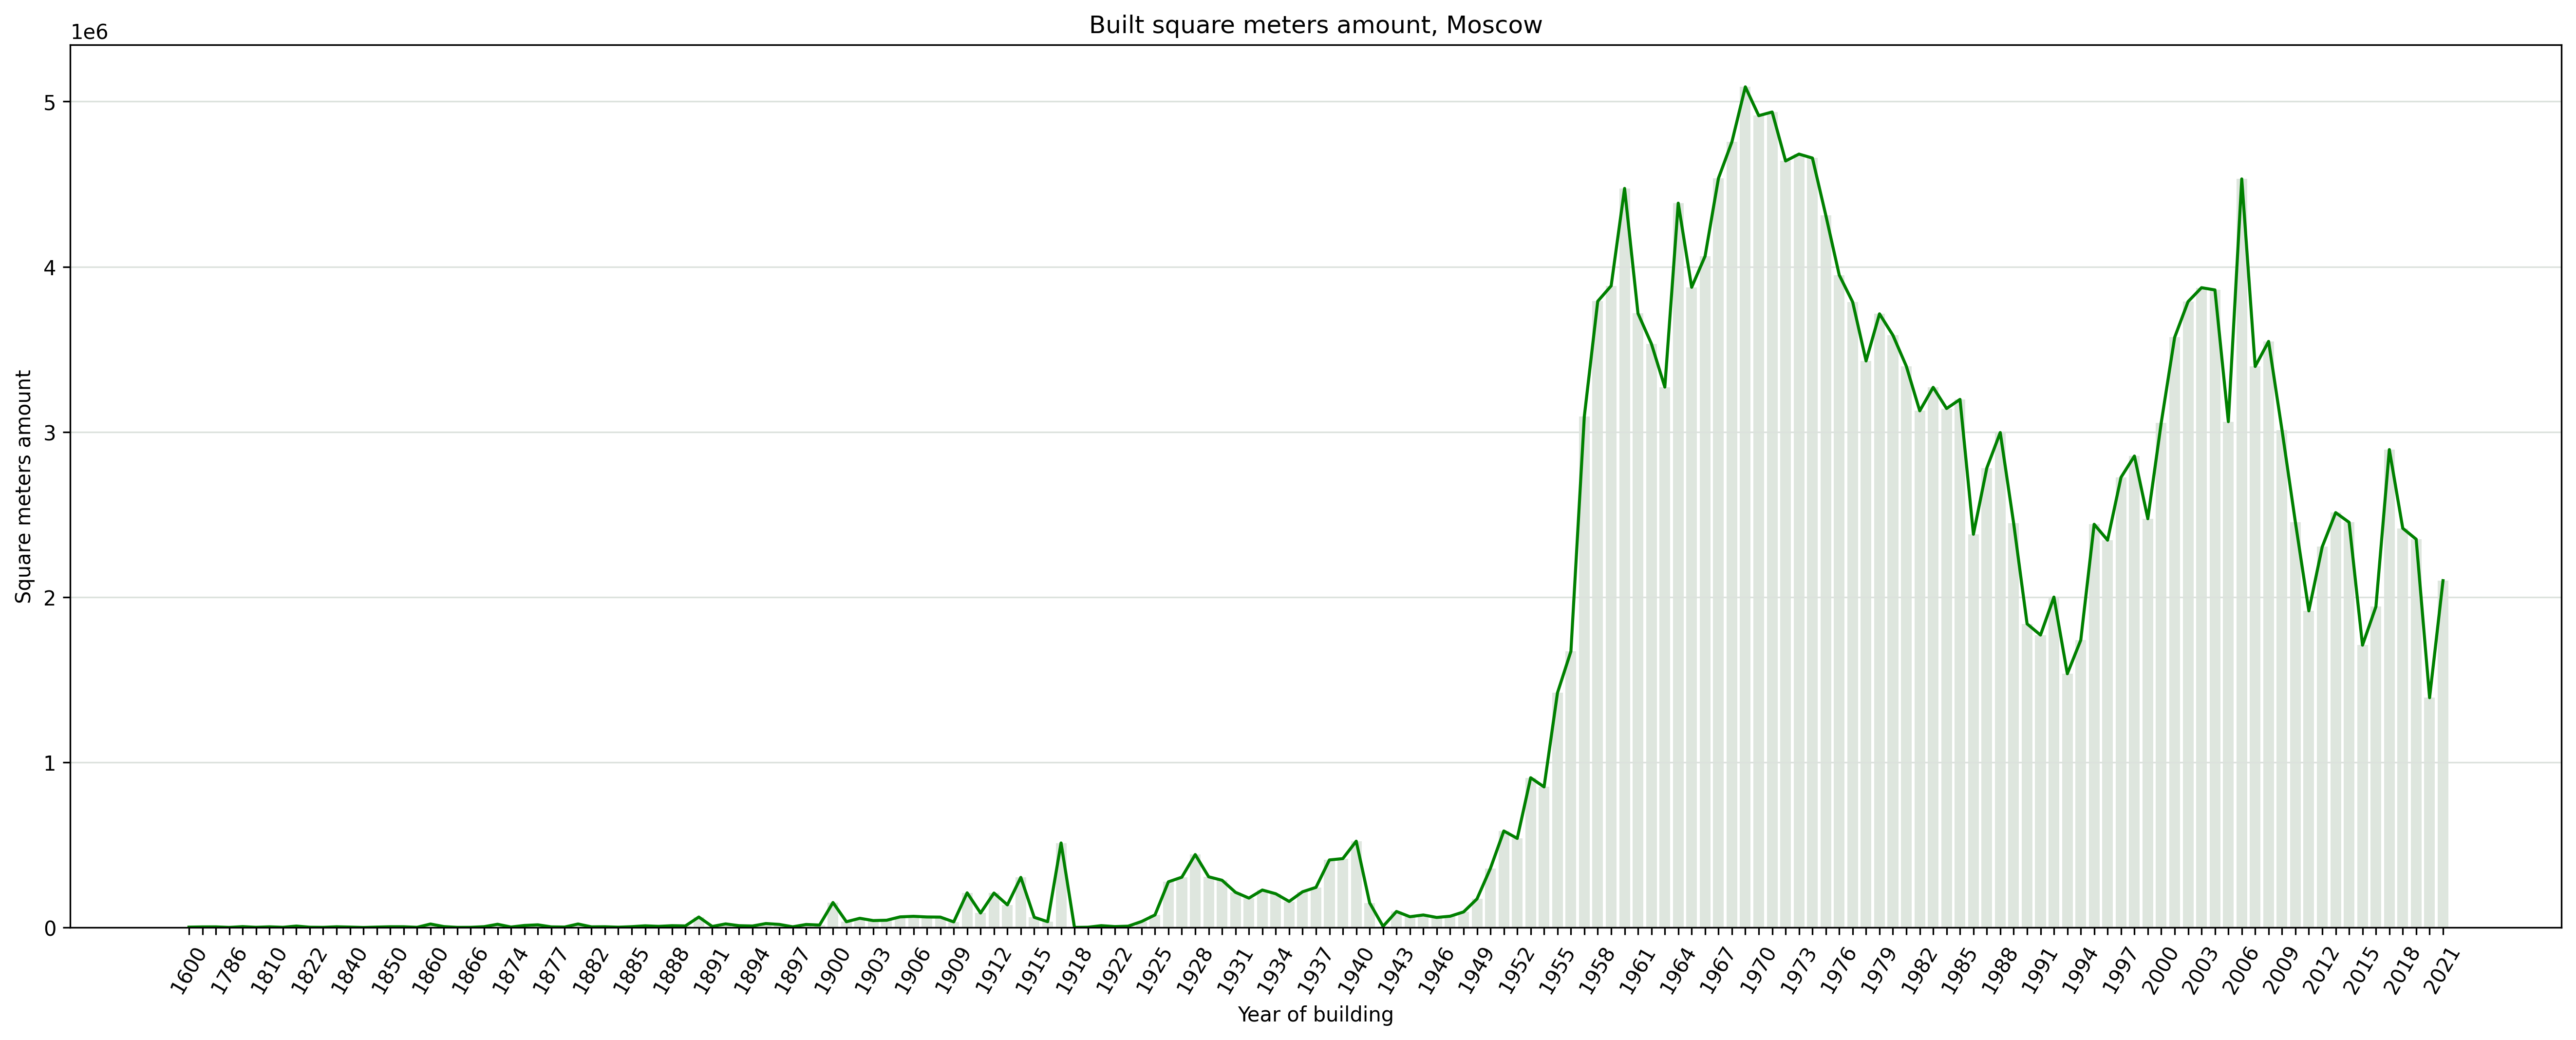

In [ ]:
# square by year distribution

square_years_list = []
for year in years_list_names:
  sq_sum = sum(df.Square.loc[df['Year'] == int(year)])
  square_years_list.append(sq_sum)

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = square_years_list,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = square_years_list,
            color = 'green')
plt.title('Built square meters amount, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Square meters amount')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_4.png')
plt.show()


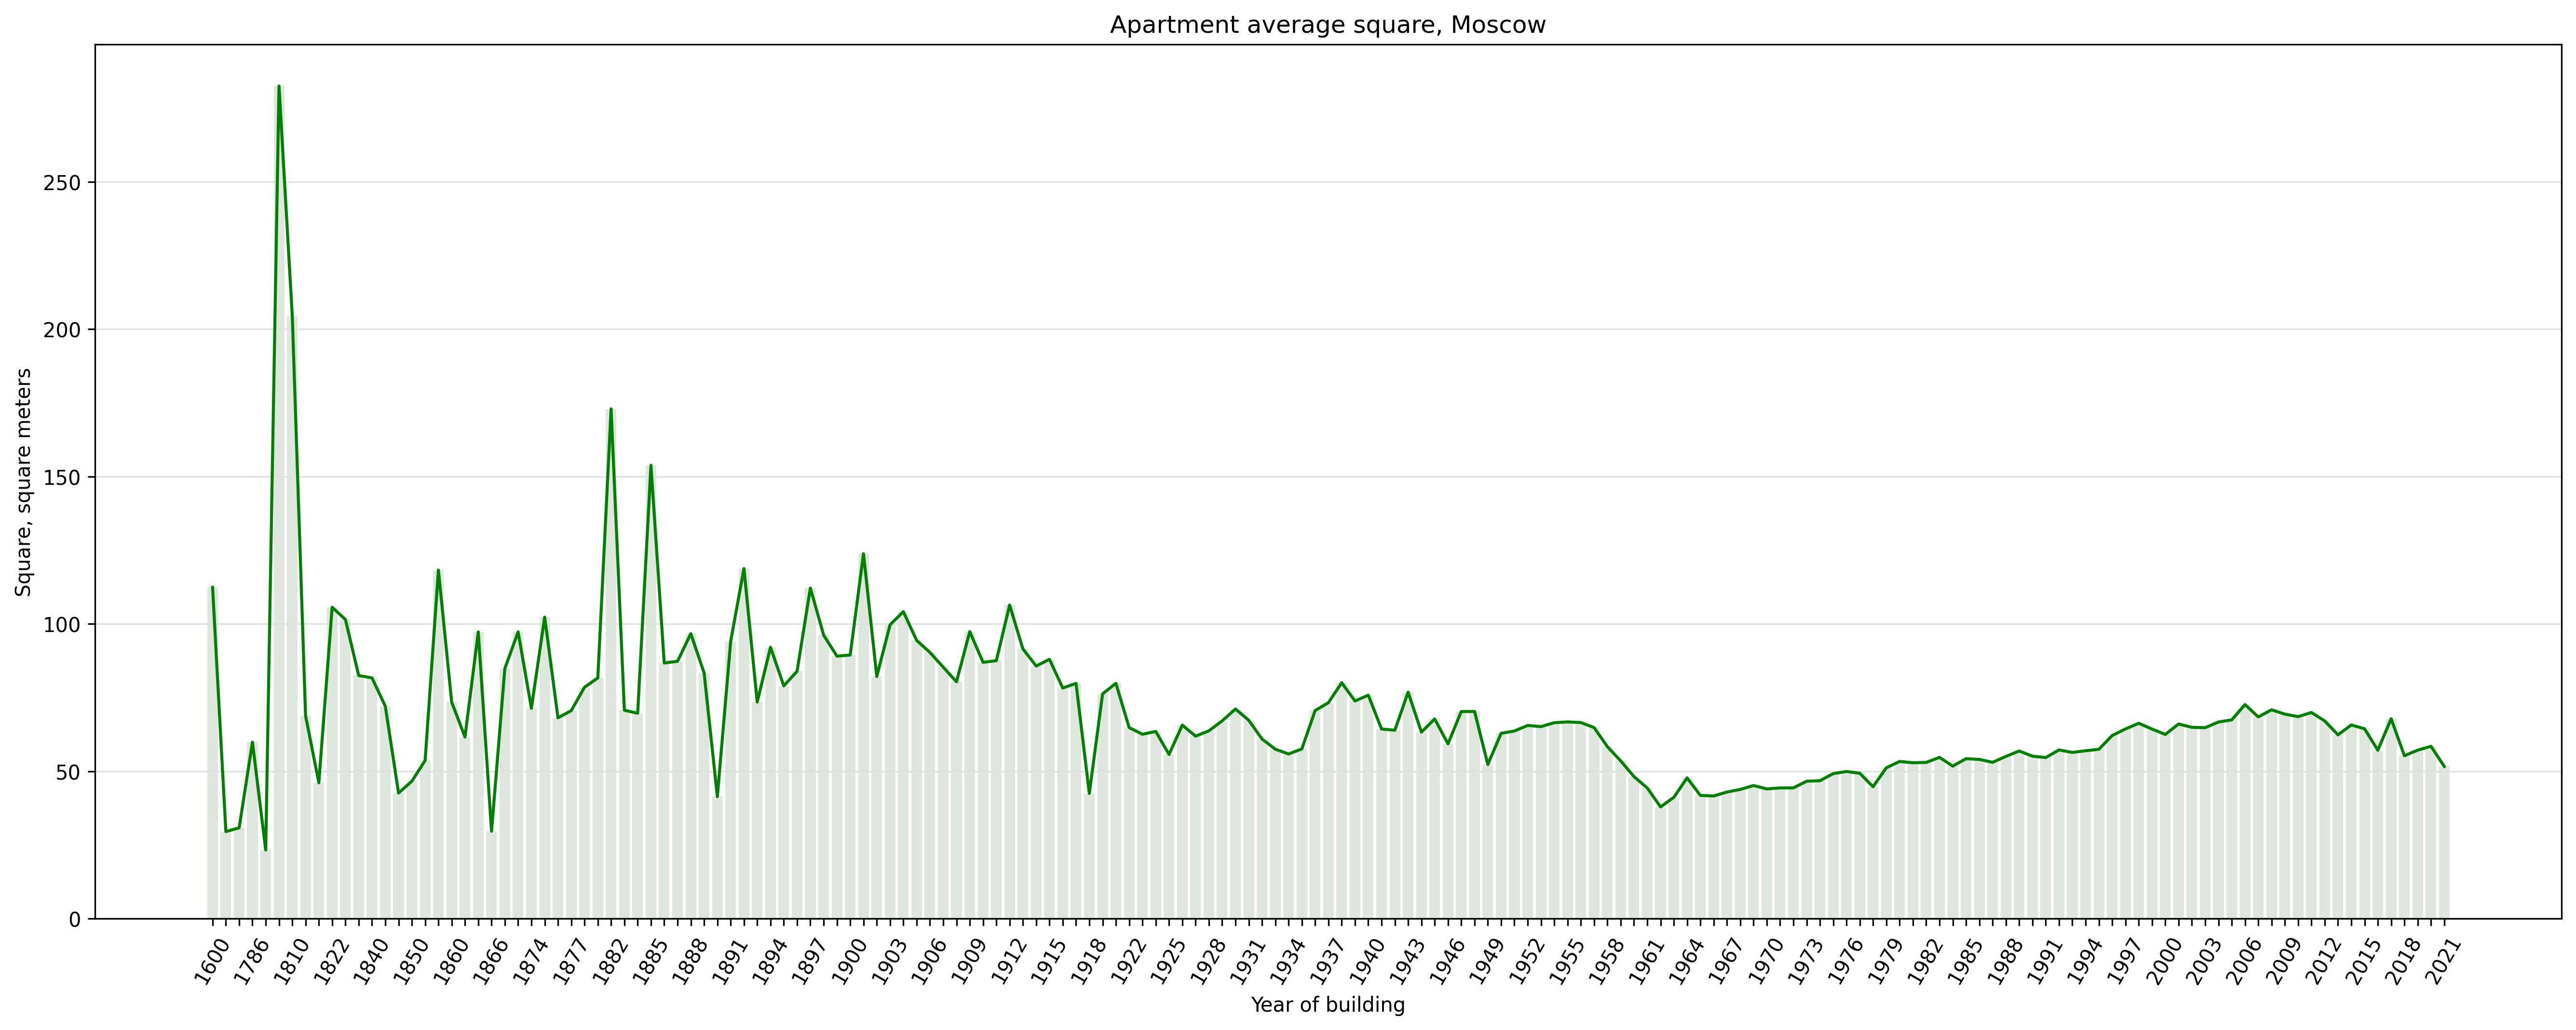

In [ ]:
# average apartment square by year distribution

flat_average_square_list = []
for year in total_years_names:
  av_sq = sum(df.Square.loc[df['Year'] == int(year)]) / sum(df.Flats.loc[df['Year'] == int(year)])
  flat_average_square_list.append(av_sq)

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = flat_average_square_list,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = flat_average_square_list,
            color = 'green')
plt.title('Apartment average square, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Square, square meters')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_5.png')
plt.show()


<ipython-input-16-1a20f9c8ae23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Flats_per_floor'] = df['Flats']/df['Entrance']/df['Height']


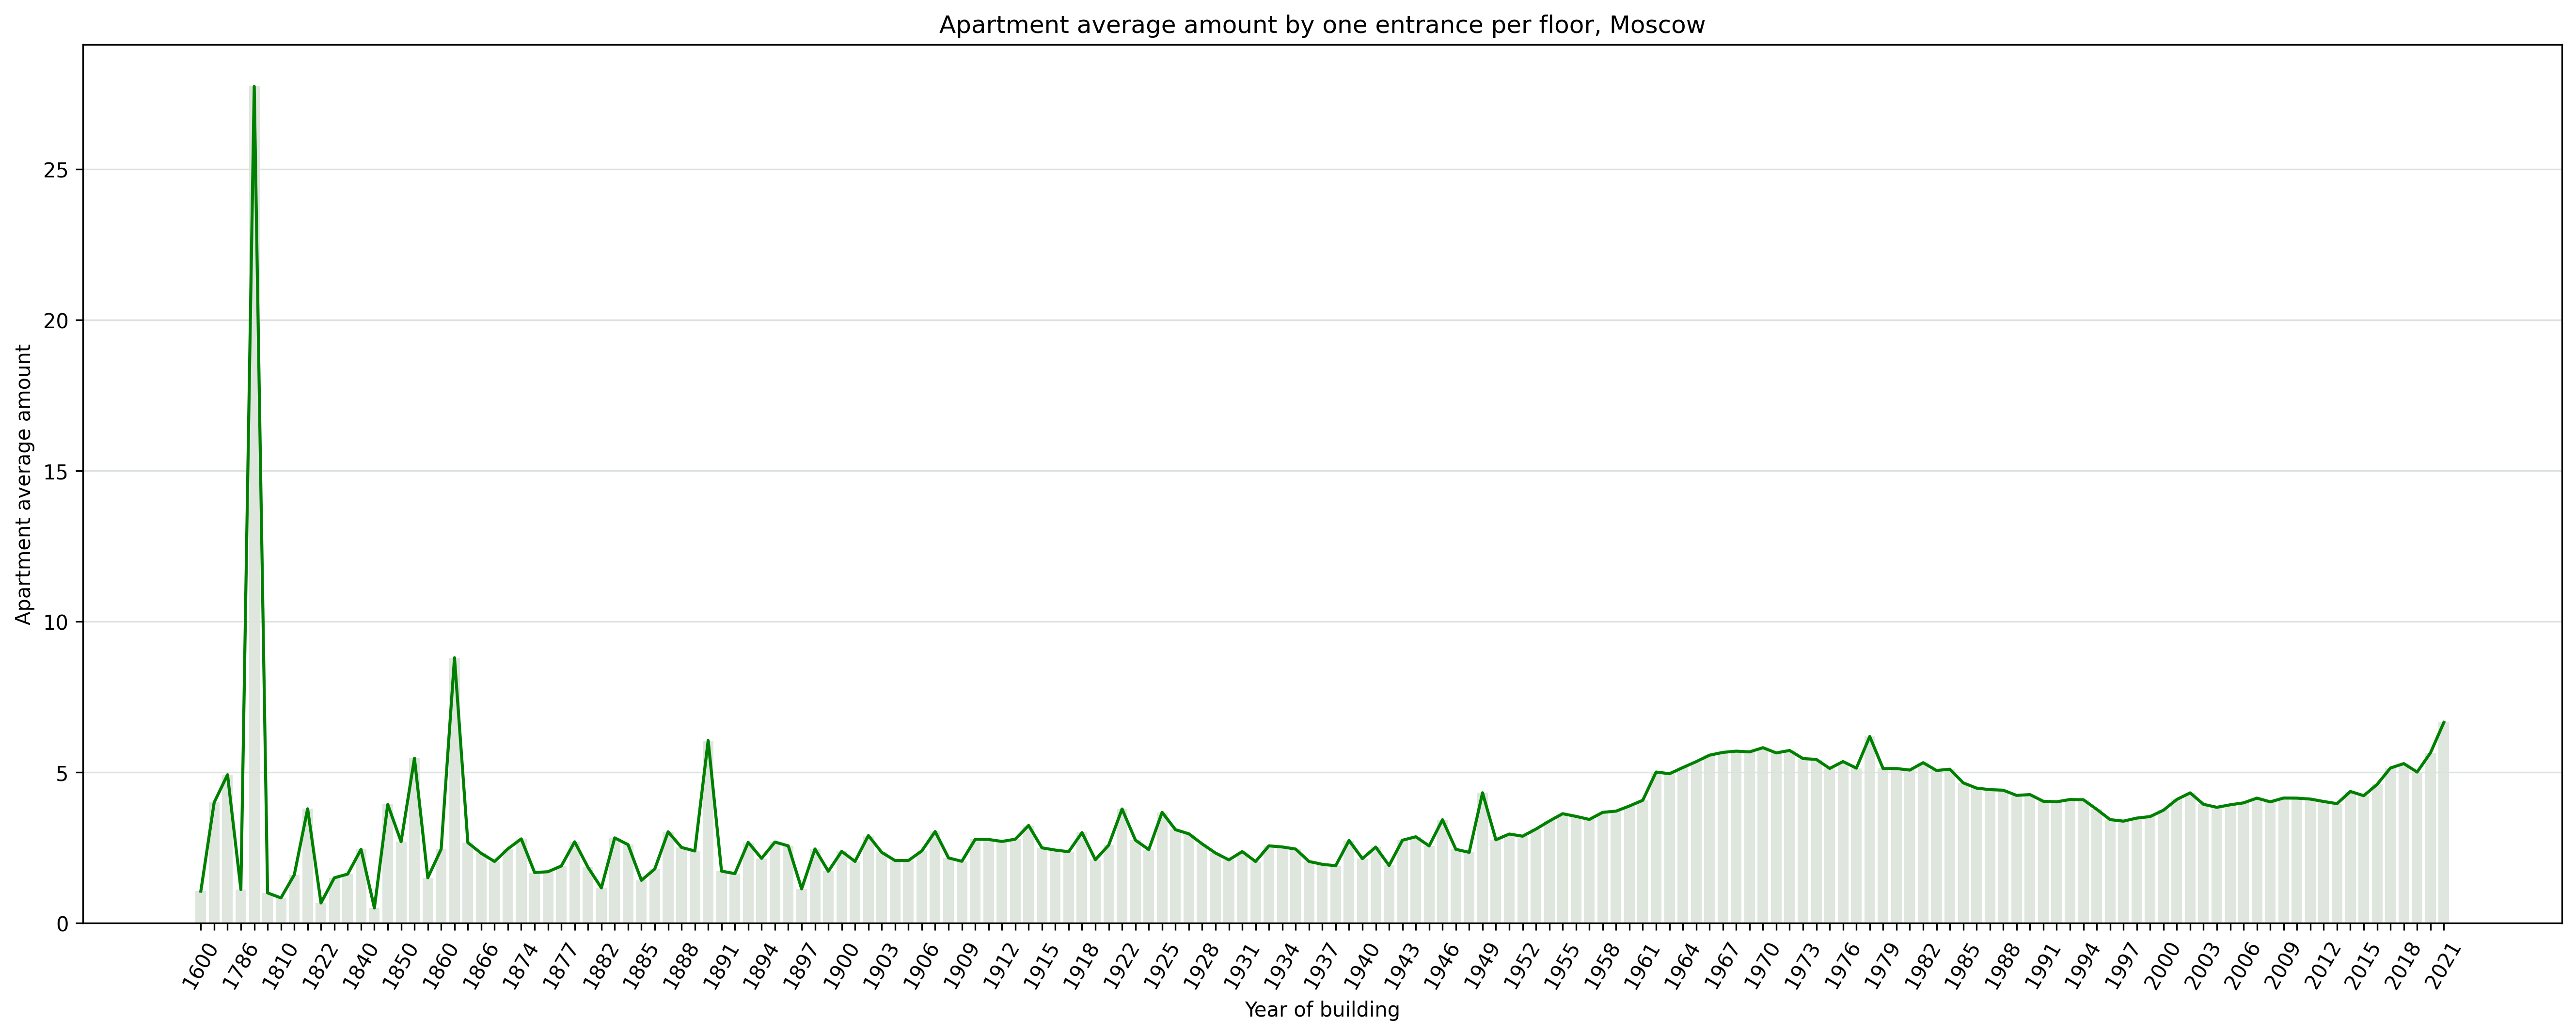

In [ ]:
# apartments by one entrance floor count

# add new column with apartments per floor of enterance value for every address
df['Flats_per_floor'] = df['Flats']/df['Entrance']/df['Height']


flat_floor_list = []
for year in total_years_names:
  fl_fl = sum(df.Flats_per_floor.loc[df['Year'] == int(year)]) / len(df.Flats_per_floor.loc[df['Year'] == int(year)])
  flat_floor_list.append(fl_fl)
  
fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = flat_floor_list,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = flat_floor_list,
            color = 'green')
plt.title('Apartment average amount by one entrance per floor, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Apartment average amount')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_6.png')
plt.show()



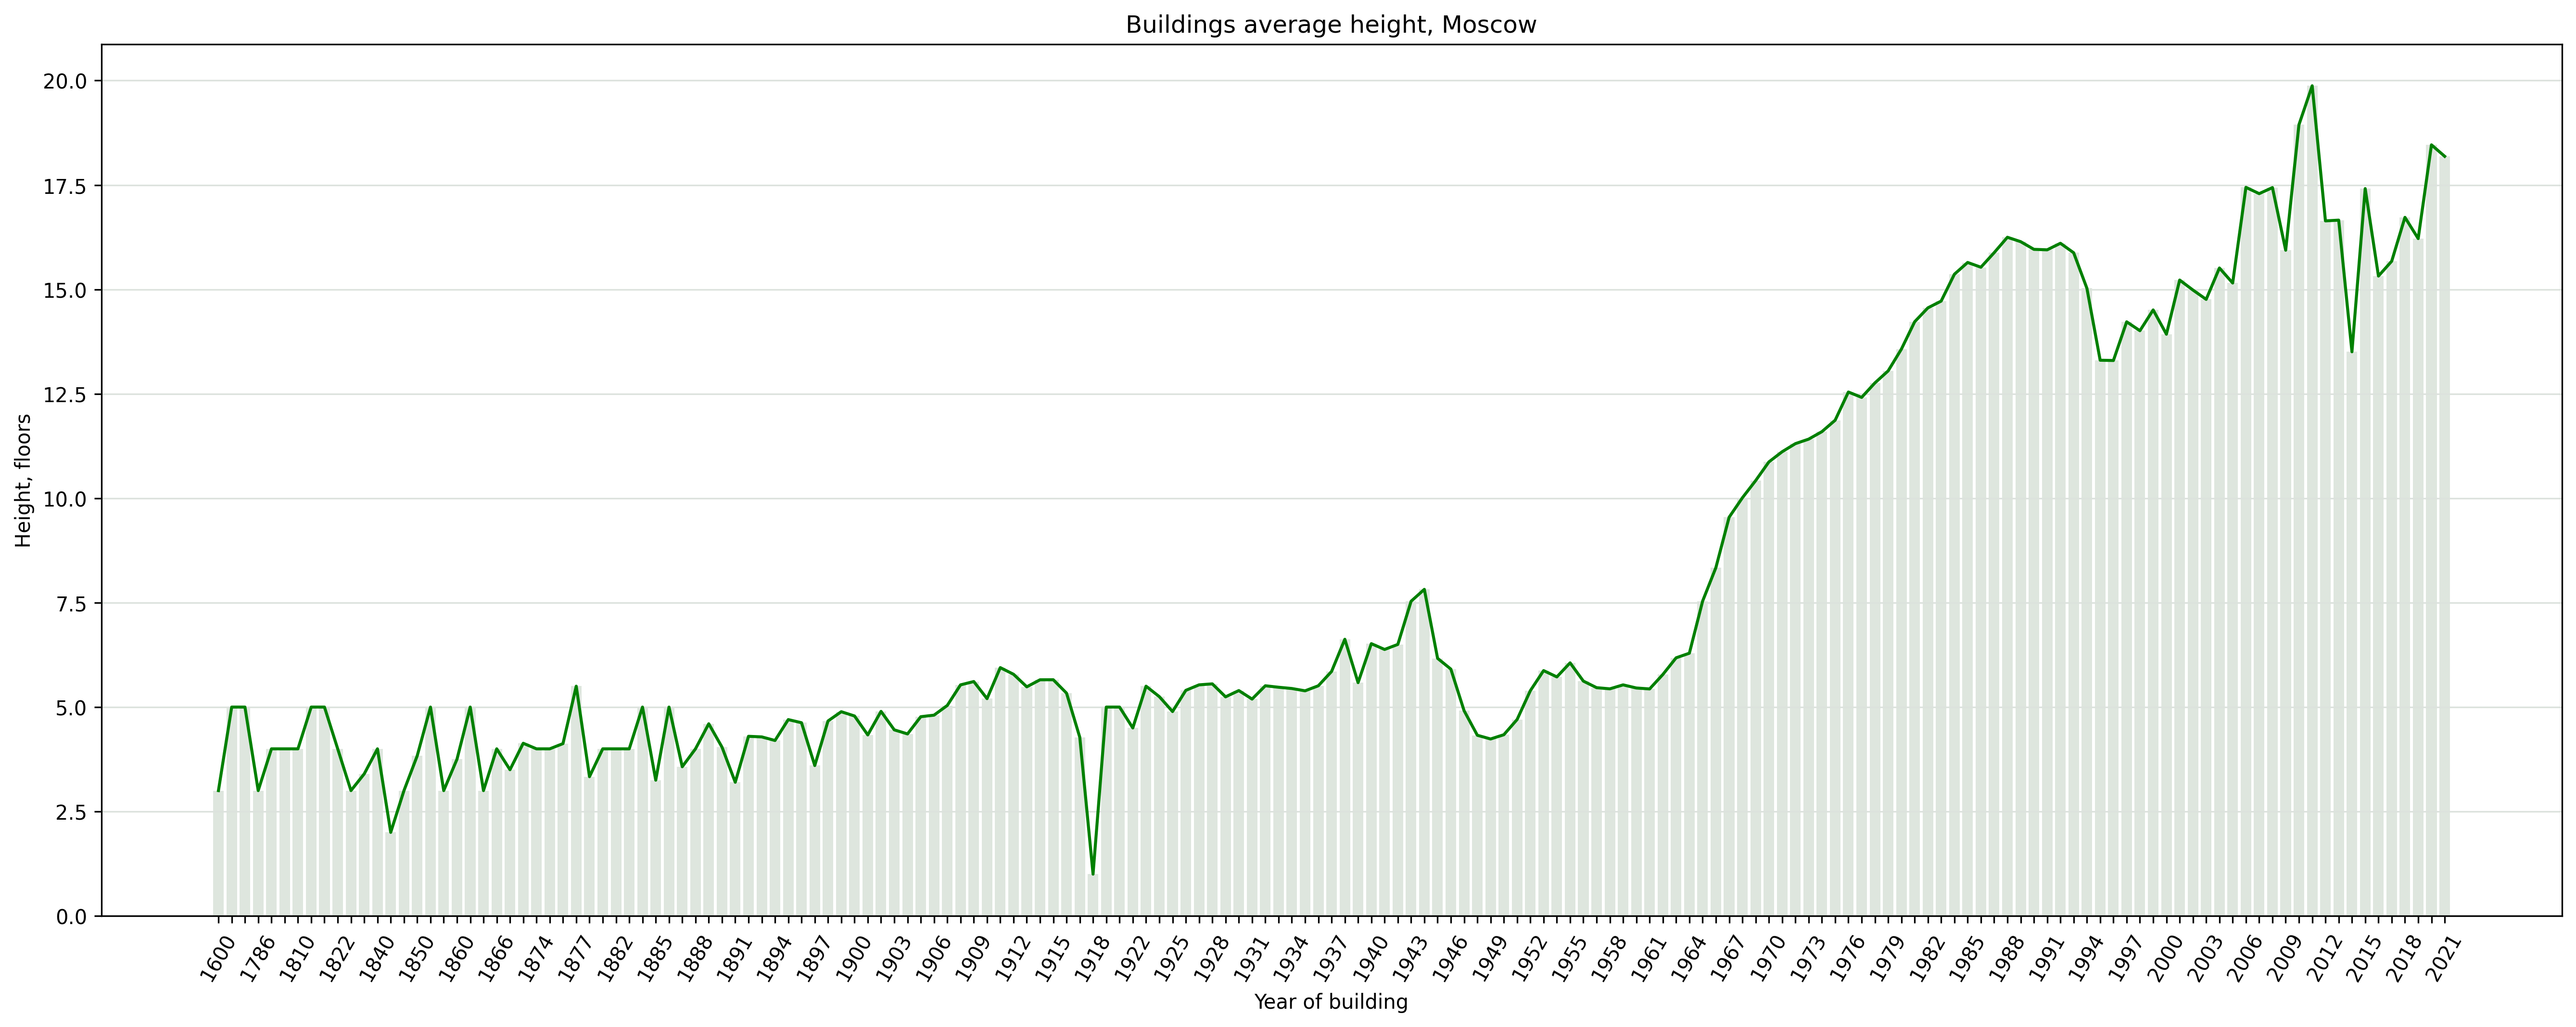

In [ ]:
# the average hight building by the years
average_height_list = []

for year in total_years_names:
  av_height = sum(df.Height.loc[df['Year'] == int(year)]) / len(df.Height.loc[df['Year'] == int(year)])
  average_height_list.append(av_height)

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = average_height_list,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = average_height_list,
            color = 'green')

plt.title('Buildings average height, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Height, floors')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_7.png')
plt.show()


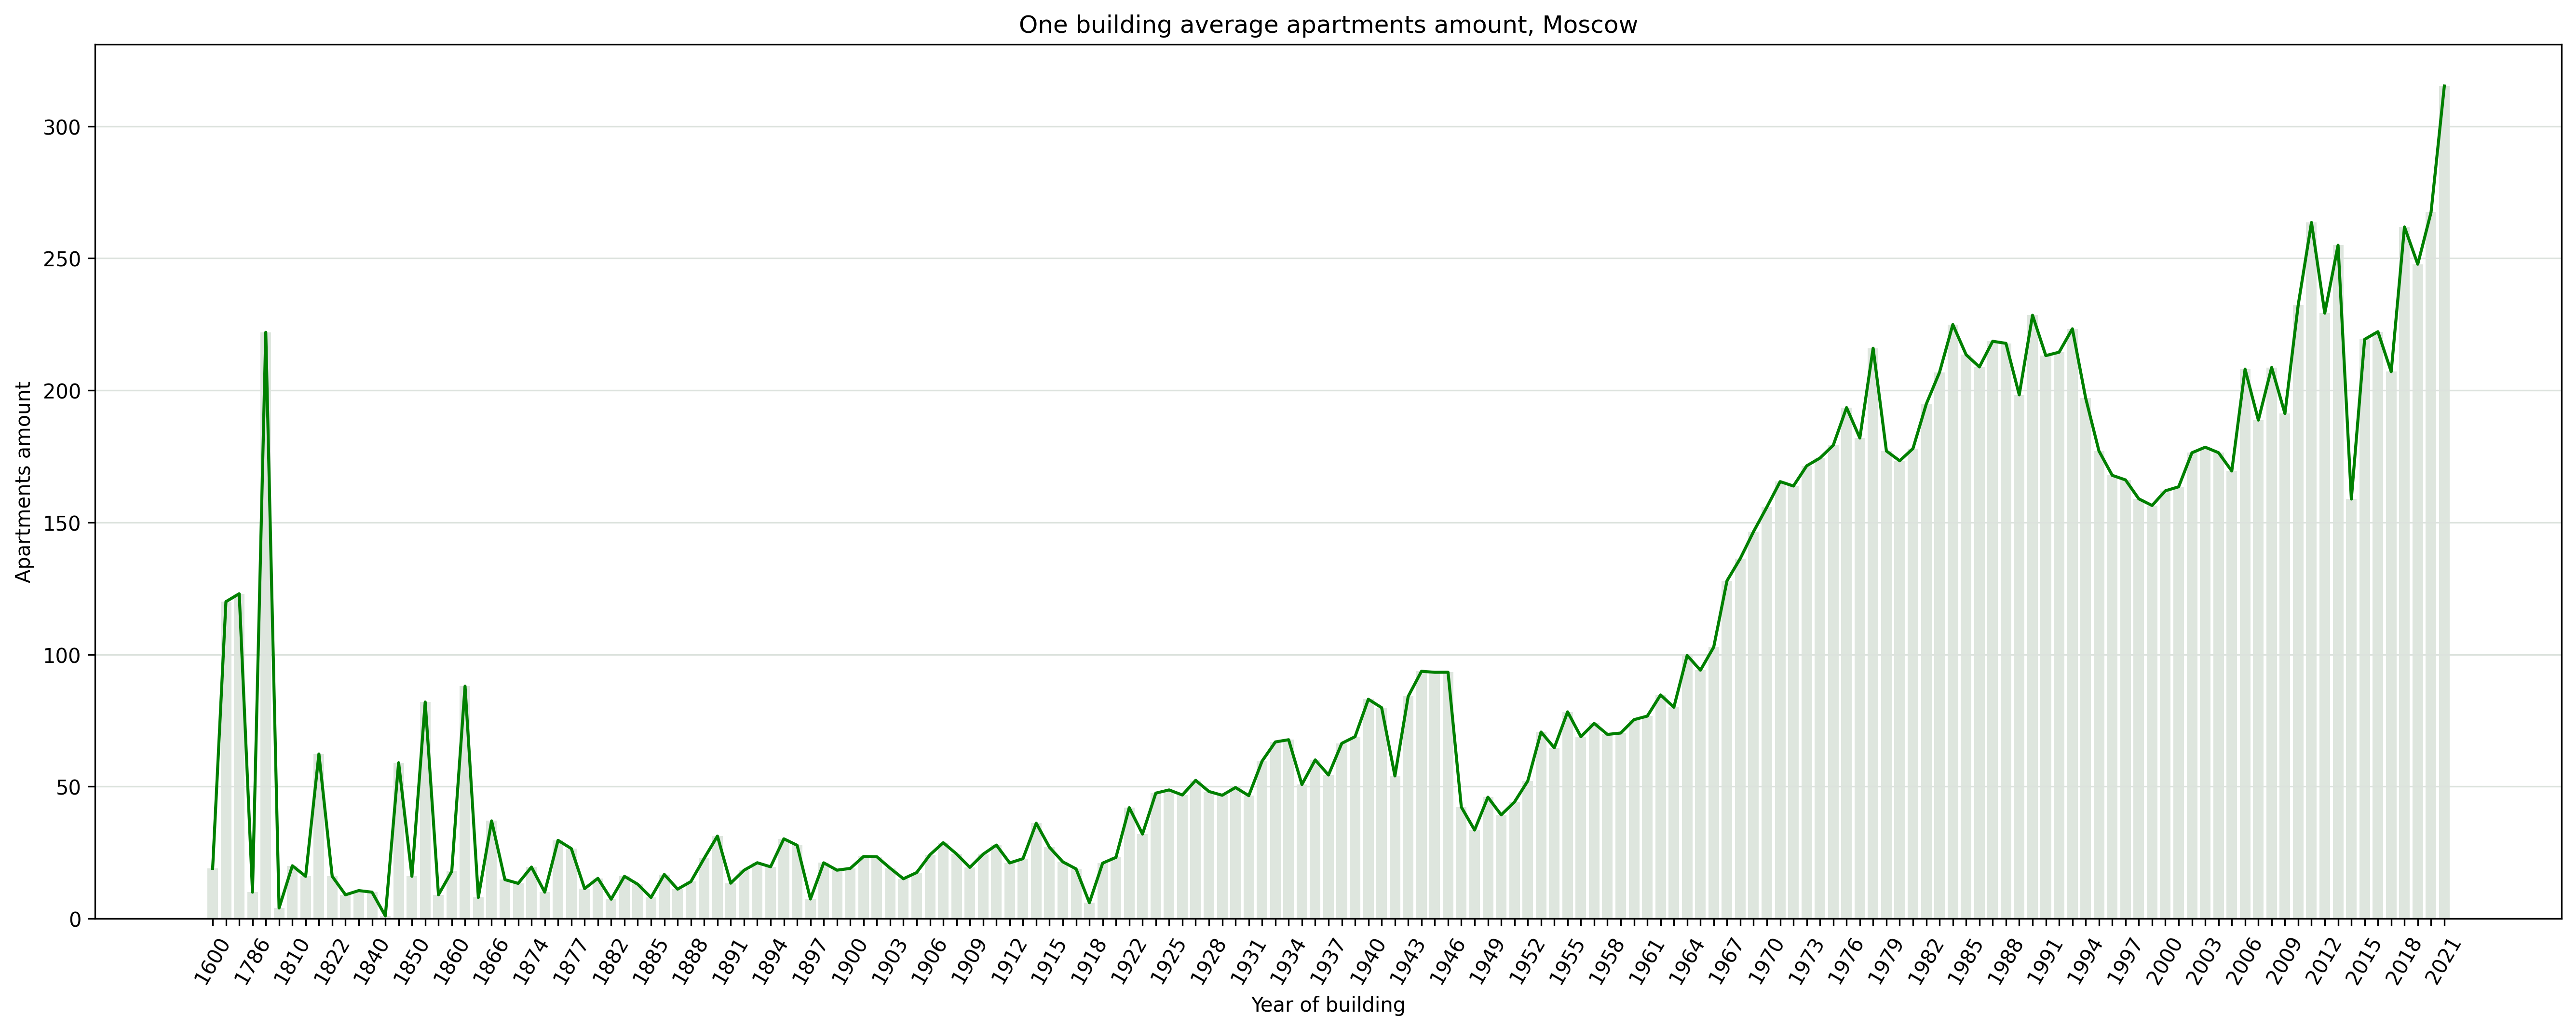

In [ ]:
# average apartments amount in 1 building for every year
average_flats_list = []
for year in total_years_names:
  build_list = df.Flats[df.Year == int(year)].values
  average_flats_value = sum(build_list) / len(build_list)
  average_flats_list.append(average_flats_value)

fig, ax = plt.subplots(figsize=(22, 8), dpi = 300)
sns.barplot(x = years_list_names, y = average_flats_list,
            color = '#dce8dd')
sns.lineplot(x = years_list_names, y = average_flats_list,
            color = 'green')
plt.title('One building average apartments amount, Moscow')
plt.xlabel('Year of building')
plt.xticks(rotation=60)
plt.ylabel('Apartments amount')
plt.grid(axis = 'y', color = '#dce2dd')
# specify number of ticks on x-axis
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.savefig('pictures/moscow_plot_8.png')
plt.show()


In [ ]:
# streets count 
streets_list = []
address_list = df.Address
for text in address_list:
  street = text.split(',')[0]
  streets_list.append(street)

df['Street'] = streets_list
df_str_count = df['Street'].value_counts().tolist()
df_str_names = df['Street'].value_counts().keys().tolist()


top_25_str = df_str_names[:25]

# list of all possible height 
height_list_increase = sorted(list(map(int, height_list_names)))

all_streets_height = []
for name in top_25_str:
  # 1 d array for current street with 0 counters for every height
  height_street_l = list(range(len(height_list_increase)))
  height_street_list = [0 for el in height_street_l]

  # street name match in Address
  for h in range(len(df)):
    if name in df.Address[h]:
      # height match in Address
      for i in range(len(height_list_increase)):
        if df.Height[h] == height_list_increase[i]:
          height_street_list[i] +=1
  all_streets_height.append(height_street_list)

<ipython-input-19-122615135be3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Street'] = streets_list


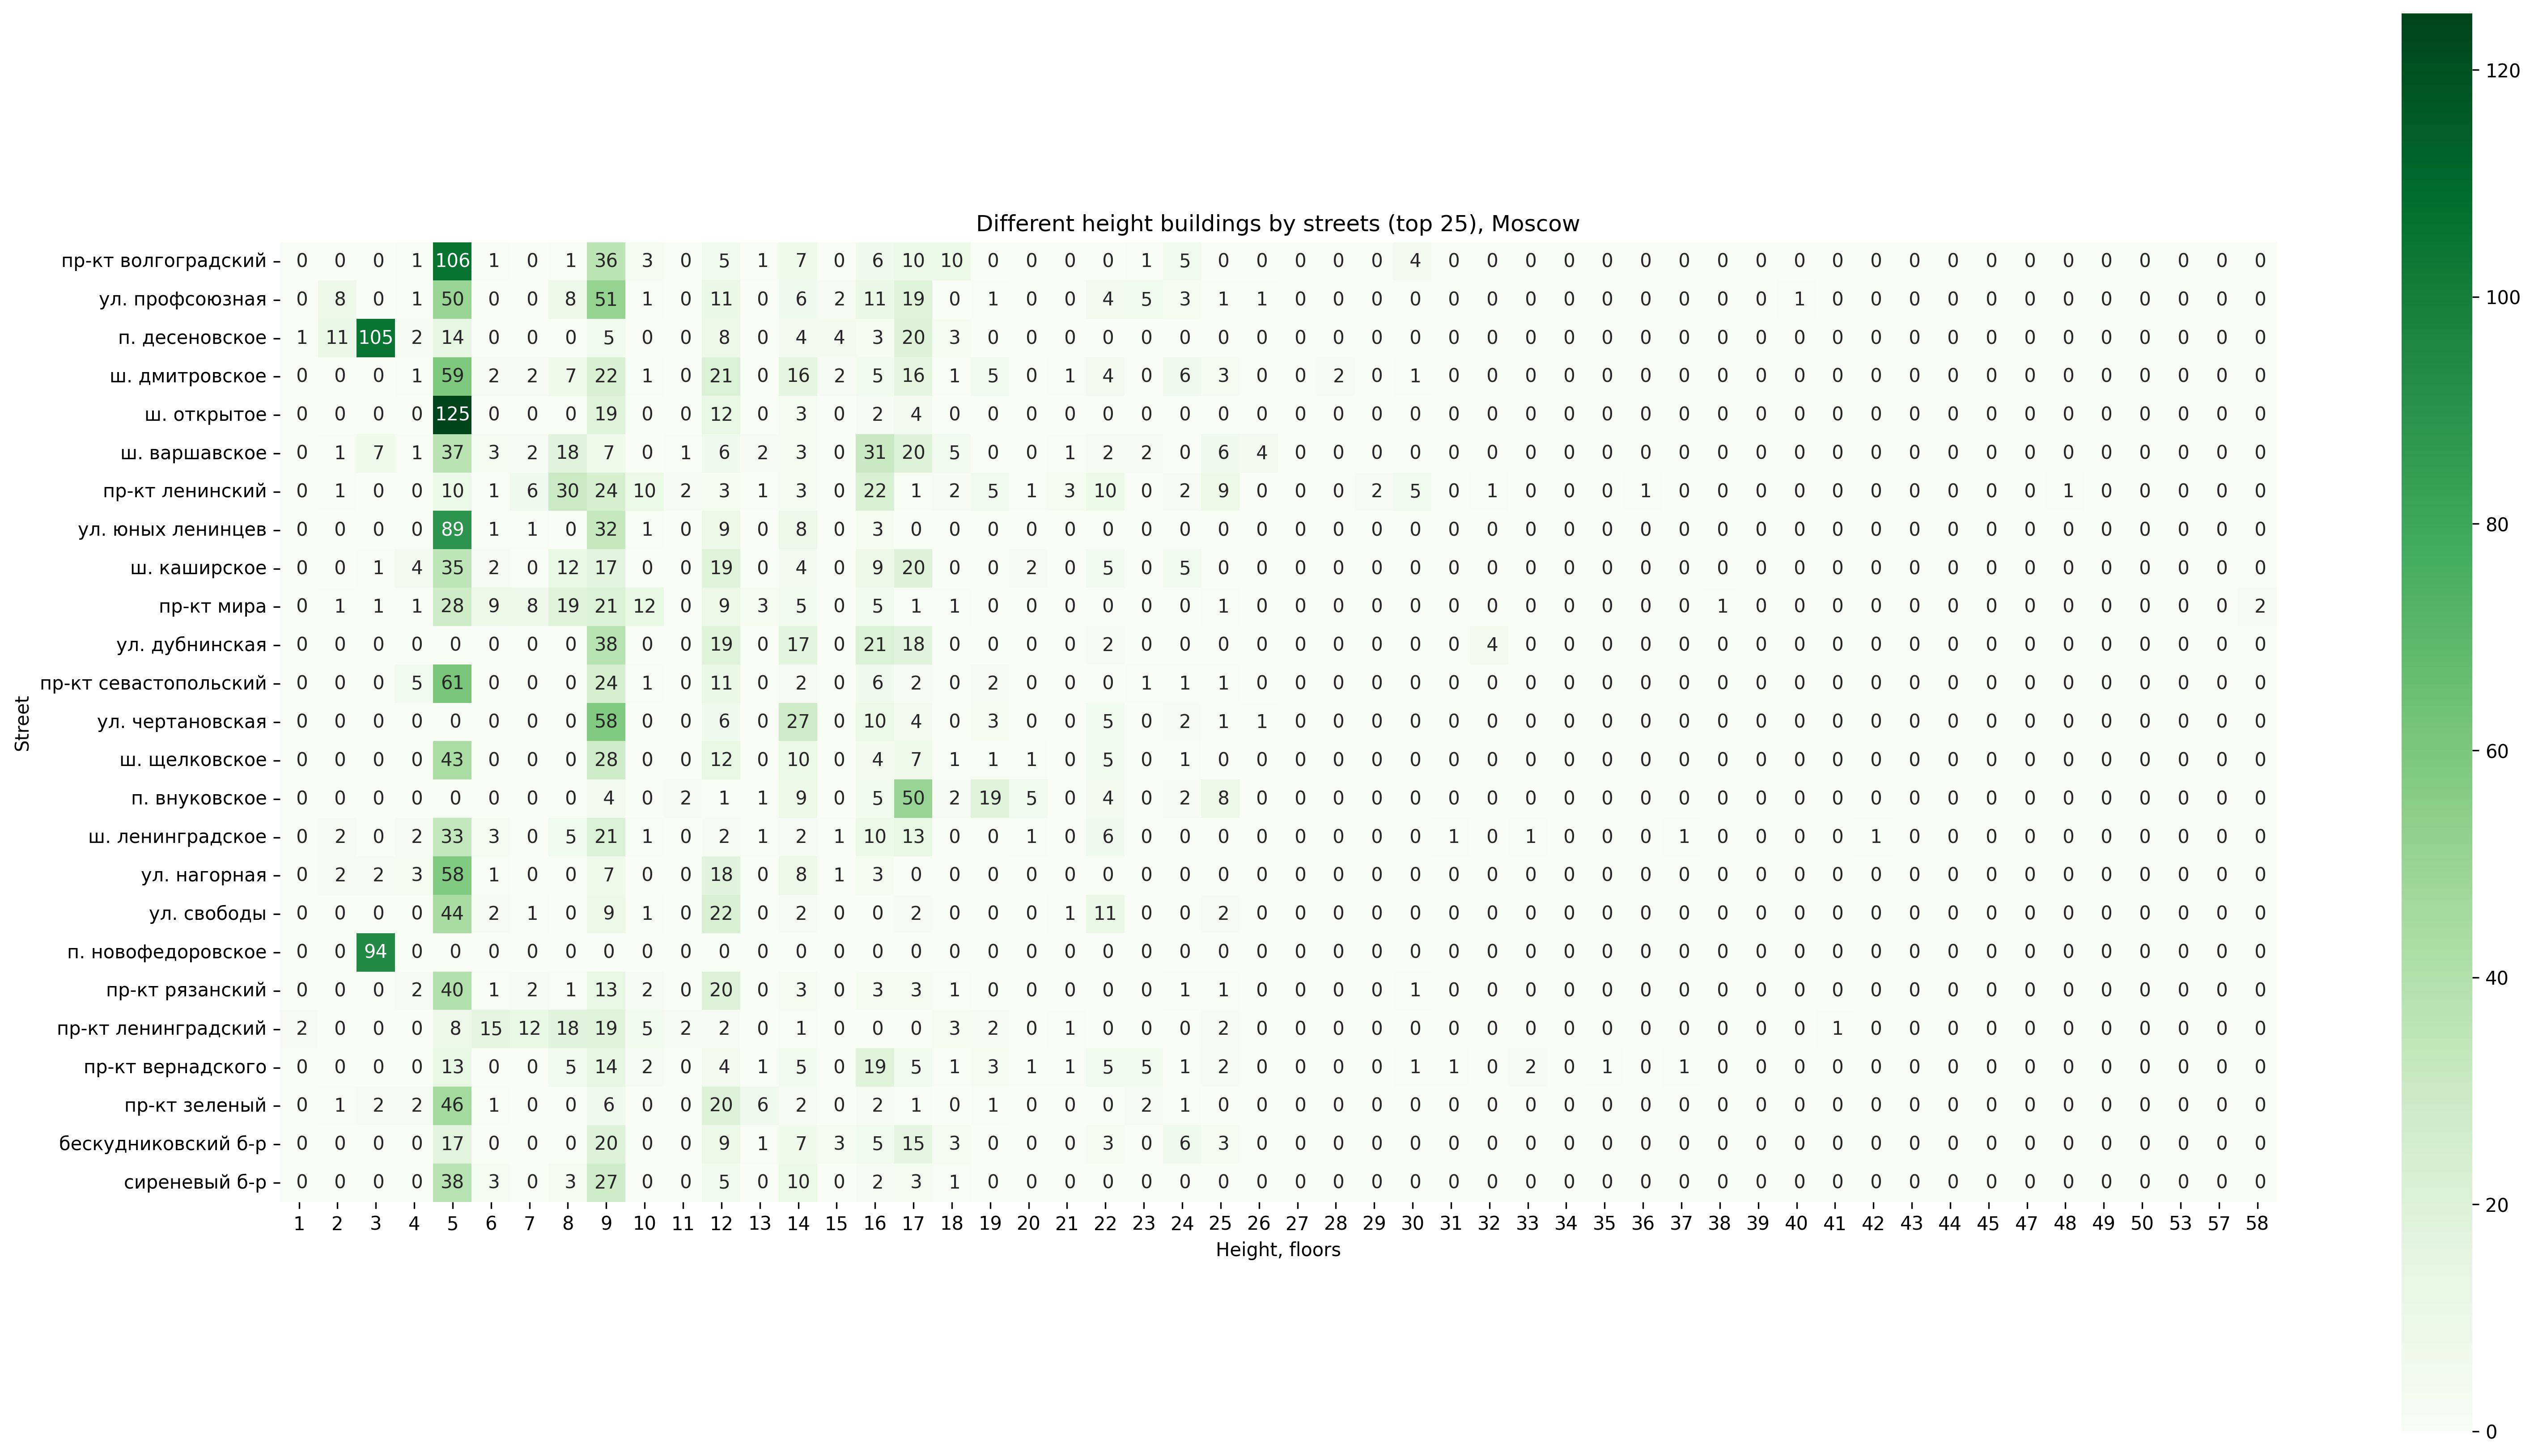

In [ ]:
fig, ax = plt.subplots(figsize=(24, 14), dpi = 300)
sns.heatmap(all_streets_height, annot = True,
            square = True, 
            fmt = '2g',
            xticklabels = height_list_increase, 
            yticklabels = top_25_str, 
            cmap = 'Greens')
plt.title('Different height buildings by streets (top 25), Moscow')
plt.xlabel('Height, floors')
plt.ylabel('Street')
plt.savefig('pictures/moscow_plot_9.png')
plt.show()


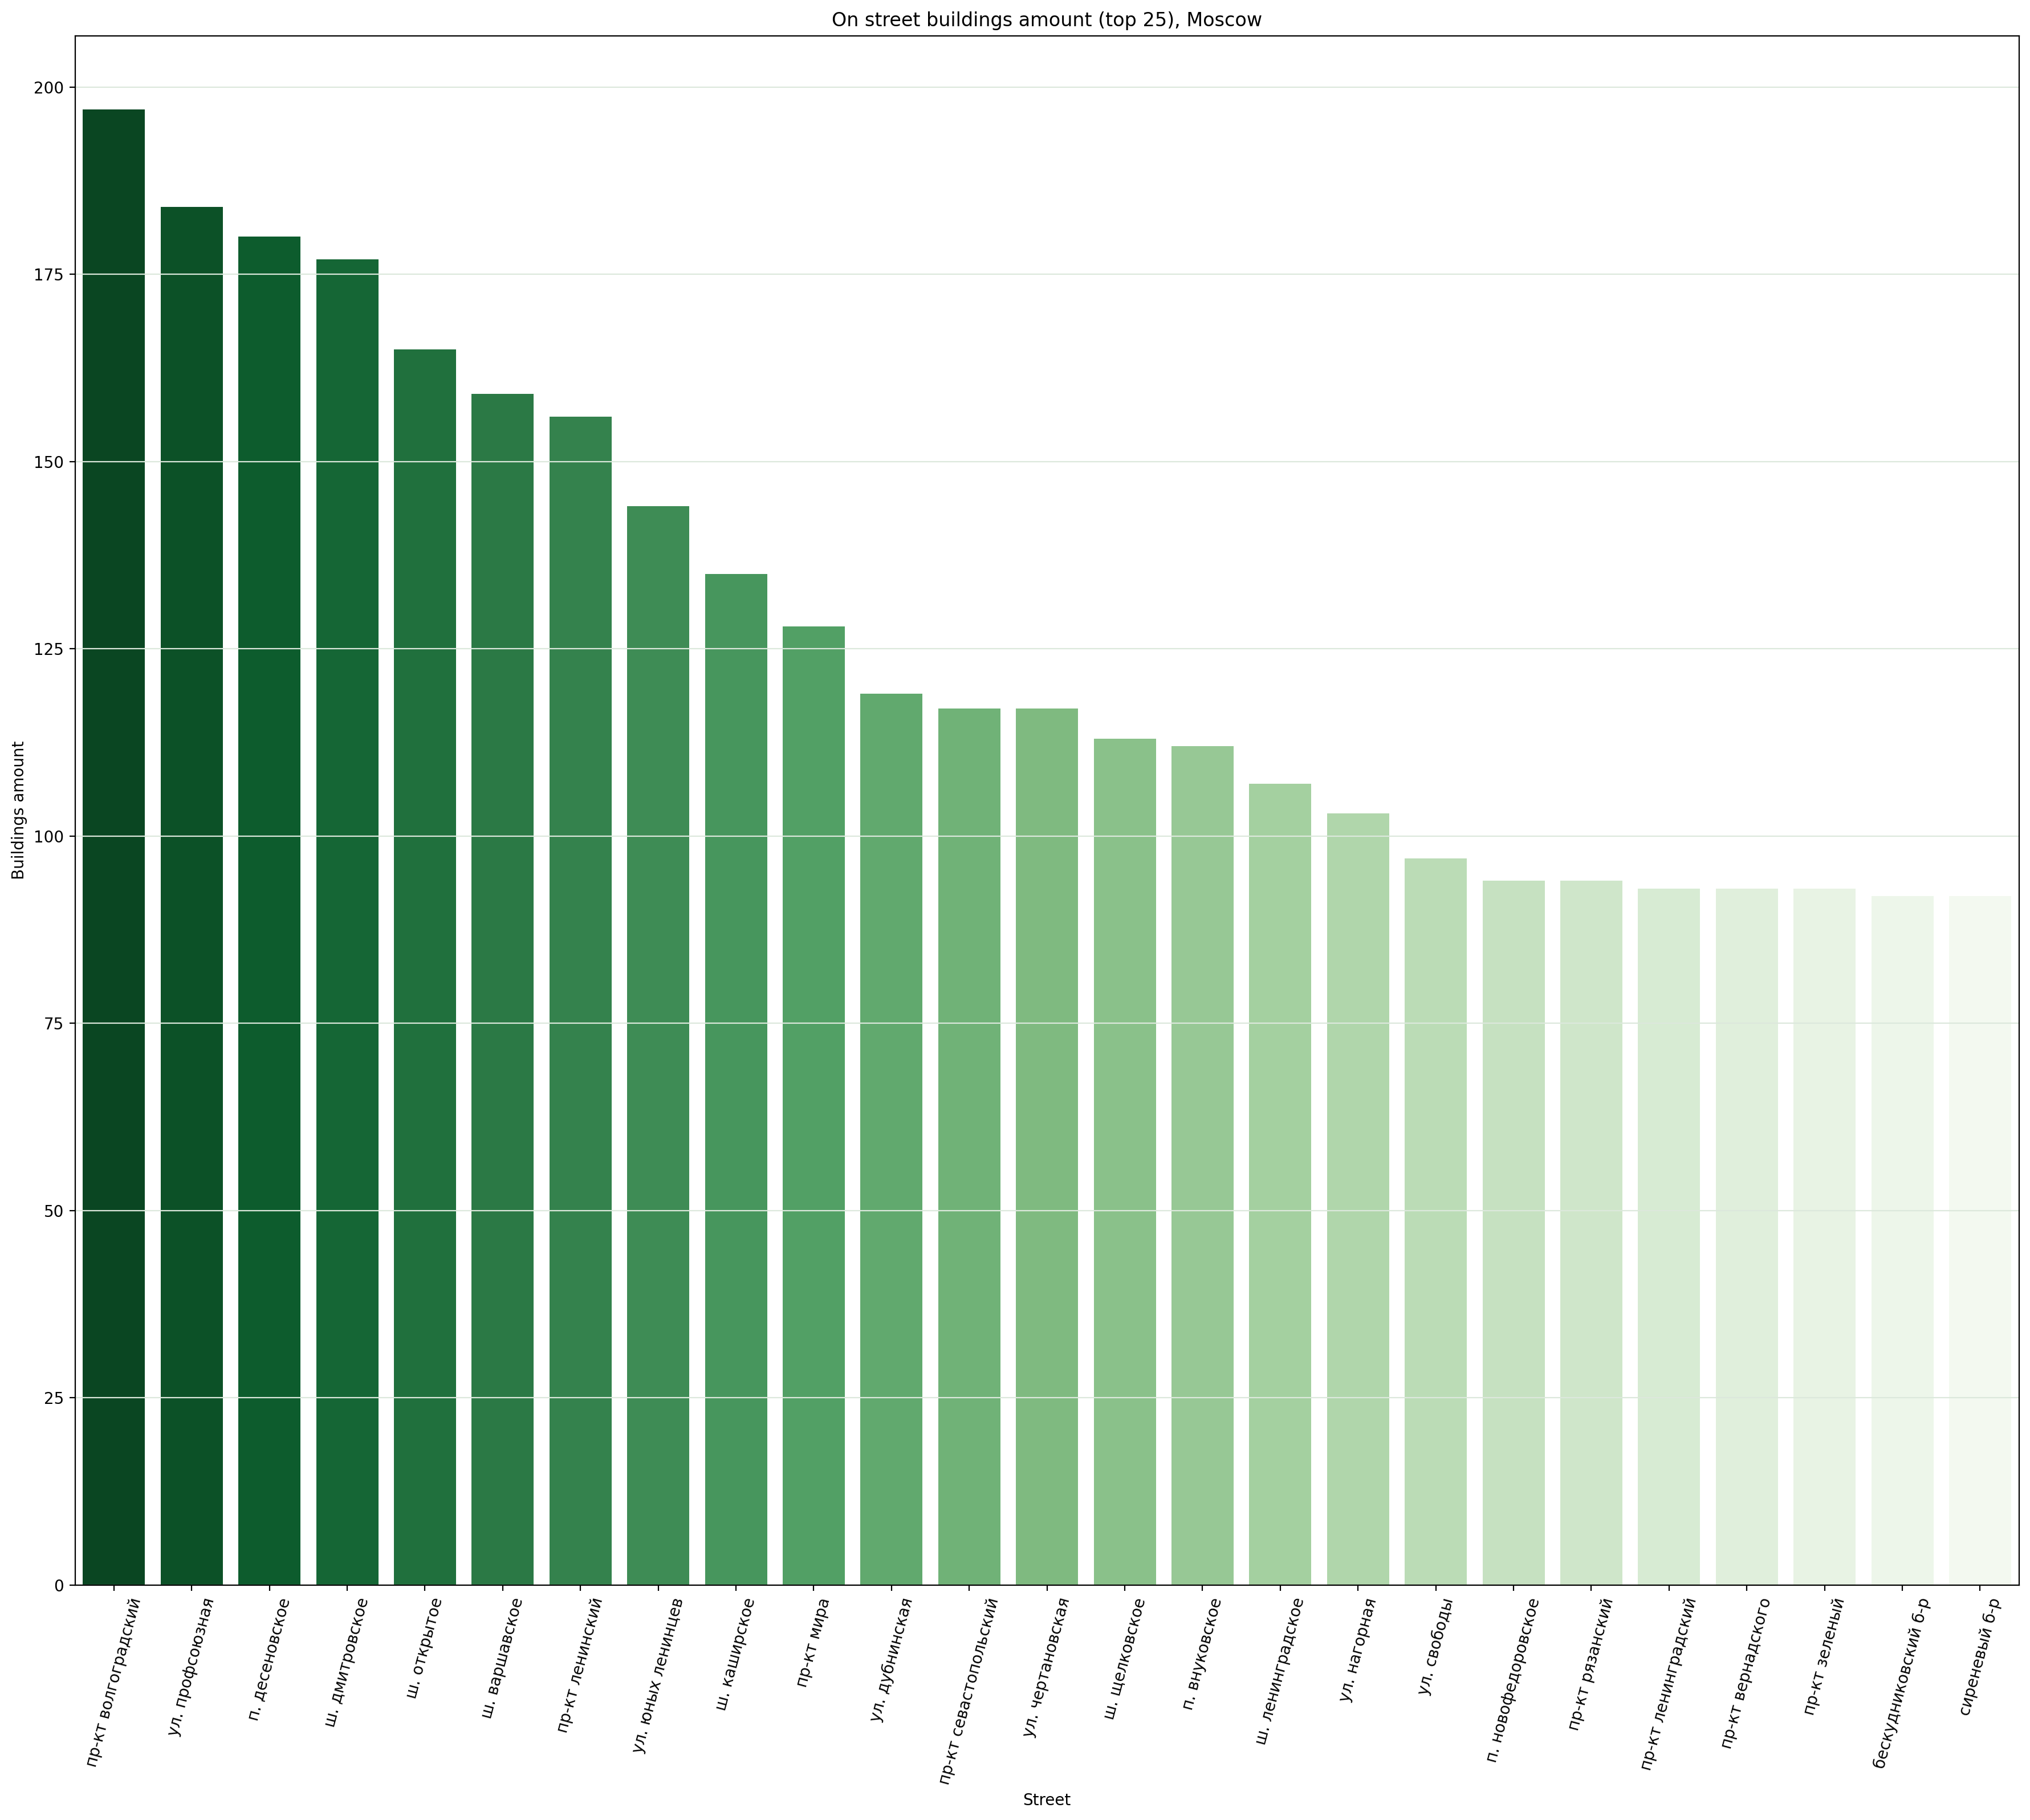

In [ ]:
# streets addresses count
fig, ax = plt.subplots(figsize= (22, 18), dpi = 200)

sns.barplot(x = df_str_names[:25], y = df_str_count[:25],
            palette = 'Greens_r')
plt.title('On street buildings amount (top 25), Moscow')
plt.xlabel('Street')
plt.xticks(rotation=75)
plt.ylabel('Buildings amount')
plt.grid(axis = 'y', color = '#dce8dc')
plt.savefig('pictures/moscow_plot_10.png')
plt.show()


In [ ]:
# top strets df
top_str_df = pd.DataFrame({'Street': df_str_names,
                           'Count': df_str_count})
print(f'{len(top_str_df)} streets parsed' )

2195 streets parsed


In [ ]:
# save dataframe as csv 
df.to_csv('data/moscow_buildings_df_full.csv')

## 3. Geo analysis visualization

In [12]:
geo_year_param_list = list(map(list, zip(df['Latitude'], df['Longitude'], df['Year'])))
map_year = folium.Map(location=[55.755042, 37.621589], zoom_start=10, tiles= 'cartodb positron') # location is Moscow center

HeatMap(geo_year_param_list, radius= 2, blur=2).add_to(map_year)
colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin = min(df.Year),
                                          vmax = max(df.Year),
                                          caption = 'Year of build')
colormap.add_to(map_year)
map_year.save('heatmaps/moscow_heatmap_year.html')

map_year

In [ ]:
geo_height_param_list = list(map(list, zip(df['Latitude'], df['Longitude'], df['Height'])))
map_height = folium.Map(location=[55.755042, 37.621589], zoom_start=10, tiles= 'cartodb positron') # location is Moscow center

HeatMap(geo_height_param_list, radius= 2, blur=2).add_to(map_height)
colormap = branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin = min(df.Height),
                                          vmax = max(df.Height),
                                          caption = 'Height of building')
colormap.add_to(map_height)
map_height.save('heatmaps/moscow_heatmap_height.html')

map_height